# Evaluate and repair genome-scale metabolic models
Script to read in the SBML v2 models, evaluate model growth at various checkpoints, and save as comets format

In [1]:
import os
os.environ['COMETS_HOME'] = '/projectnb2/talbot-lab-data/zrwerbin/interactions/comets_2.10.5_linux'
os.environ['JAVA_HOME'] = '/share/pkg.7/java/12.0.1/install'
os.environ['PATH'] = '/projectnb/talbot-lab-data/zrwerbin/metagenomics/metaGEM/:/projectnb2/talbot-lab-data/zrwerbin/venvs/comets/bin:/share/pkg.7/gurobi/9.1.1/install/bin:/share/pkg.7/python3/3.8.10/install/bin:/share/pkg.7/java/12.0.1/install/bin:/usr/java/default/jre/bin:/usr/java/default/bin:/usr/lib64/qt-3.3/bin:/usr/local/bin:/usr/bin:/usr/local/sbin:/usr/sbin:/sbin:/opt/dell/srvadmin/bin:/bin:/projectnb2/talbot-lab-data/zrwerbin/interactions/comets_2.10.5_linux:/usr3/graduate/shall16/.local/bin'
#model_dir = "./models" # model location
import sys
#!{sys.executable} -m pip install cobra # install memote if needed
#!{sys.executable} -m pip install cometspy # install memote if needed
import cobra
import cobra.test # for the ijo1366 model
import copy
import numpy as np
import pandas as pd
import cometspy as c


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Model evaluation

In [2]:
model_in = cobra.io.read_sbml_model('/projectnb2/talbot-lab-data/metabolic_models/genomes/solibacter/solibacter.xml')

Using license file /usr/local/gurobi/gurobi.lic
Set parameter TokenServer to value sccsvc


In [6]:
model_in.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
Larab_e,EX_Larab_e,166.7,15,23.20%
abg4_e,EX_abg4_e,0.03096,12,0.00%
ala_his_e,EX_ala_his_e,4.385,9,0.37%
arg__L_e,EX_arg__L_e,23.92,6,1.33%
ca2_e,EX_ca2_e,0.2409,0,0.00%
cellb_e,EX_cellb_e,500,12,55.69%
cl_e,EX_cl_e,0.2409,0,0.00%
cobalt2_e,EX_cobalt2_e,0.004628,0,0.00%
cu2_e,EX_cu2_e,0.03281,0,0.00%
cytd_e,EX_cytd_e,6.179,9,0.52%


Above, the summary included a section called Objective, which means they are being optimized. This should be something called "growth" or "biomass" - edit the next command accordingly, so that it will tell us details about this reaction.

In [7]:
#model_in.reactions.get_by_id('Growth')

Some commands that we have to run when converting a model to the special COMETS format.

In [8]:
model_c = c.model(model_in)
model_c.ensure_sinks_are_not_exchanges()
model_c.open_exchanges()

Each species will have biomass seeded at 50 different locations. We will use the helper function pick_random_locations for this. After setting initial population locations, the models are finished, so we add them to the layout.


In [9]:
from cometspy.utils import grow_rocks, pick_random_locations
grid_width =  20 
grid_height =  20
founders_per_species = 50
n_species = 1
init_locs = pick_random_locations(n = founders_per_species*n_species, 
                                   xrange = [1,grid_width], yrange = [1,grid_height])
spec1_locs = init_locs[1:founders_per_species]
model_c.initial_pop = [[loc[0],loc[1],1e-8] for loc in spec1_locs]

If we wish to take a look at what locations were chosen, we can make an image with matplotlib:

In [10]:
from matplotlib import pyplot as plt
initial_image = np.zeros((grid_height,grid_width,3))
for loc in spec1_locs:
    initial_image[loc[1]-1,loc[0]-1,0] = 1
plt.figure(figsize = (5,5))
plt.imshow(initial_image)

<Figure size 500x500 with 0 Axes>

Next we setup the simulation parameters, which don't need to change between tests. This includes things like death rate, and the types of data that are saved.


In [11]:
params = c.params()
params.set_param('timeStep', .1) # in hours
params.set_param('maxCycles', 100)
params.set_param('maxSpaceBiomass', 5) # gDW # max biomass allowed per cell
params.set_param('deathRate', 0.0001) # die at rate of 1/10000 per hour
params.set_param('defaultKm', 0.000001) # may need to be changed by species
params.set_param('writeBiomassLog', True)
params.set_param('writeTotalBiomassLog', True)
params.set_param('BiomassLogRate', 50)
params.set_param('totalBiomassLogRate', 20)
params.set_param('numRunThreads', 28)
#params.set_param("writeSpecificMediaLog", True)
#params.set_param("specificMediaLogRate", 1) # time steps

## Test 1: Growth with/without carbon source

Next we create a bunch of scenarios to test the growth of this microbe.  In this first realistic simulation, we want some metabolites available initially. These include all the typical trace nutrients needed, so we start with the helper function.

In [9]:
realistic_layout = c.layout()
realistic_layout.grid = [grid_width,grid_height]
realistic_layout.add_model(model_c)

realistic_layout.set_specific_metabolite('h2_e',1000)
realistic_layout.set_specific_metabolite('so3_e',1000)
realistic_layout.set_specific_metabolite('glc__D_e',0.0000001)
realistic_layout.set_specific_metabolite('meoh_e',0.00000001)
realistic_layout.set_specific_metabolite('cys__L_e',0.0000001)

building empty layout model
models will need to be added with layout.add_model()


In [10]:
realistic_layout.media

,diff_c,g_refresh,g_static,g_static_val,init_amount,metabolite
0,0.000005,0,0,0,0,12dgr160_e
1,0.000005,0,0,0,0,12dgr180_e
2,0.000005,0,0,0,0,1ag160_e
3,0.000005,0,0,0,0,1ag180_e
4,0.000005,0,0,0,0,1ag181d9_e
...,...,...,...,...,...,...
239,0.000005,0,0,0,0,xyl__D_e
240,0.000005,0,0,0,0,xylan4_e
241,0.000005,0,0,0,0,xylan8_e
242,0.000005,0,0,0,0,xylb_e


Next, we'll copy the layout but remove glucose and L-cysteine to make sure it doesn't grow without carbon. To check what a certain metabolite is, look up the code in the BiGG database: http://bigg.ucsd.edu/

In [11]:
no_carbon_layout = copy.deepcopy(realistic_layout)
no_carbon_layout.set_specific_metabolite('glc__D_e',0)
no_carbon_layout.set_specific_metabolite('cys__L_e',0)


no_carbon_layout = c.layout()
no_carbon_layout.grid = [grid_width,grid_height]
no_carbon_layout.add_model(model_c)

building empty layout model
models will need to be added with layout.add_model()


In [12]:
sim_realistic = c.comets(realistic_layout, params)
sim_realistic.run()
print(sim_realistic.run_output)


Running COMETS simulation ...


KeyboardInterrupt: 

In [37]:
sim_no_carbon = c.comets(no_carbon_layout, params)
sim_no_carbon.run()
print(sim_no_carbon.run_output)


Running COMETS simulation ...
Done!
-script
running script file: /projectnb2/talbot-lab-data/metabolic_models/scripts/.current_script_0x2b9e7148d130
Current Java version: 12.0.1
Parameters file .current_global_0x2b9e7148d130 loaded.
Parameters file .current_package_0x2b9e7148d130 loaded.
Loading layout file '.current_layout_0x2b9e7148d130'...
null/COMETS_manifest.txt (No such file or directory)
Unable to initialize manifest file. 
Continuing without writing manifest file.
Found 1 model files!
Loading './solibacter.cmd' ...
Done!
 Testing default parameters...
Done!
Optimizer status code = 5 (looks ok!)
objective solution = 46.28223092633283
Constructing world...
Done!
medialist	12dgr160_e	12dgr180_e	1ag160_e	1ag180_e	1ag181d9_e	1ag182d9d12_e	2m35mdntha_e	34dhpac_e	34dhphe_e	35dnta_e	3amp_e	3cmp_e	3mb_e	3ump_e	4hba_e	4hbald_e	4hbz_e	4hpro_LT_e	5drib_e	5mdru1p_e	Larab_e	Lcyst_e	abg4_e	ac_e	acald_e	actn__R_e	ad_e	ade_e	adn_e	akg_e	ala_L_asp__L_e	ala_L_glu__L_e	ala_L_thr__L_e	ala_gln_e	al

Text(0, 0.5, 'Biomass (gr.)')

Text(0.5, 1.0, 'With carbon')

Text(0, 0.5, 'Biomass (gr.)')

Text(0.5, 1.0, 'Without carbon')

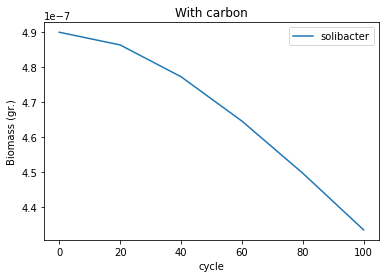

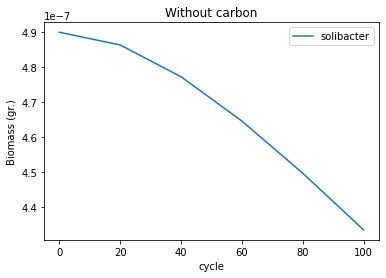

In [35]:
with_carbon_img = sim_realistic.total_biomass.plot(x = 'cycle')
with_carbon_img.set_ylabel("Biomass (gr.)")
with_carbon_img.set_title("With carbon")

without_carbon_img = sim_no_carbon.total_biomass.plot(x = 'cycle')
without_carbon_img.set_ylabel("Biomass (gr.)")
without_carbon_img.set_title("Without carbon")

In the plot above, for the no-carbon scenario, there should be no growth since we gave the microbe literally nothing to work with. 

But we do see growth??? so we can see what it's growing on by checking the uptake values from the summary section, and set those metabolites to zero.

In [41]:
# code TBD

# View any non-zero values from media list
no_carbon_layout.media[no_carbon_layout.media["init_amount"] > 0]

#sim_no_carbon.get_metabolite_time_series()

,diff_c,g_refresh,g_static,g_static_val,init_amount,metabolite


AttributeError: 'comets' object has no attribute 'media'

## Test 2: Anaerobic vs aerobic growth 

## Test 3: Changing objective function

## Test 4: Response to different glucose/oxygen levels??